In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator


# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram

Tensorflow/Keras: 2.11.0
numpy: 1.21.6
sklearn: 1.0.2
OpenCV: 4.5.4
matplotlib: 3.5.3


In [7]:
image = cv2.imread("/kaggle/input/tamil-characters/shuffled/u16_000t01.tiff", cv2.IMREAD_GRAYSCALE)
image.shape

(108, 116)

In [8]:
# Specify the location of images after you have downloaded them
ImgLocation="/kaggle/input/tamil-characters/"

CATEGORIES = set(["shuffled"])

# Create a list to store image paths
ImagePaths=[]
for category in CATEGORIES:
    for image in list(os.listdir(ImgLocation+category)):
        ImagePaths=ImagePaths+[ImgLocation+category+"/"+image]
        
# Load images and resize to 64 x 64
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
    img_resized = cv2.bitwise_not(img_resized)
    data_lowres.append(img_resized)

data_lowres = np.array(data_lowres, dtype="float")
data_lowres 

array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       ...,

       [[  0.,   0.,   0

In [9]:
# Scaler
scaler=MinMaxScaler(feature_range=(-1, 1))

# Select images that we want to use for model trainng
data=data_lowres.copy()
print("Original shape of the data: ", data.shape)

# Reshape array
data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)

# Fit the scaler
scaler.fit(data)

# Scale the array
data=scaler.transform(data)

# Reshape back to the original shape
data=data.reshape(data_lowres.shape[0], 64, 64, 1)
print("Shape of the scaled array: ", data.shape)

Original shape of the data:  (3000, 64, 64)
Reshaped data:  (12288000, 1)
Shape of the scaled array:  (3000, 64, 64, 1)


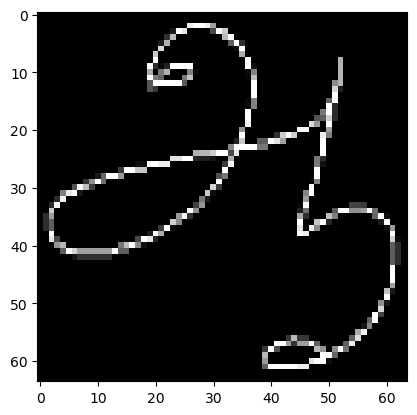

In [19]:
img = cv2.resize(data[563], dsize=(64,64), interpolation=cv2.INTER_LINEAR)
plt.imshow(img, cmap='gray')

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 8192)             827392    
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-Resh  (None, 8, 8, 128)        0         
 ape-1 (Reshape)                                                 
                                                                 
 Generator-Hidden-Layer-2 (C  (None, 16, 16, 128)      262272    
 onv2DTranspose)                                                 
                                                                 
 Generator-Hidden-Layer-Acti  (None, 16, 16, 128)      0         
 vation-2 (ReLU)                                                 
                                                                 
 Generator-Hidden-Layer-3 (C  (None, 32, 32, 256)      52

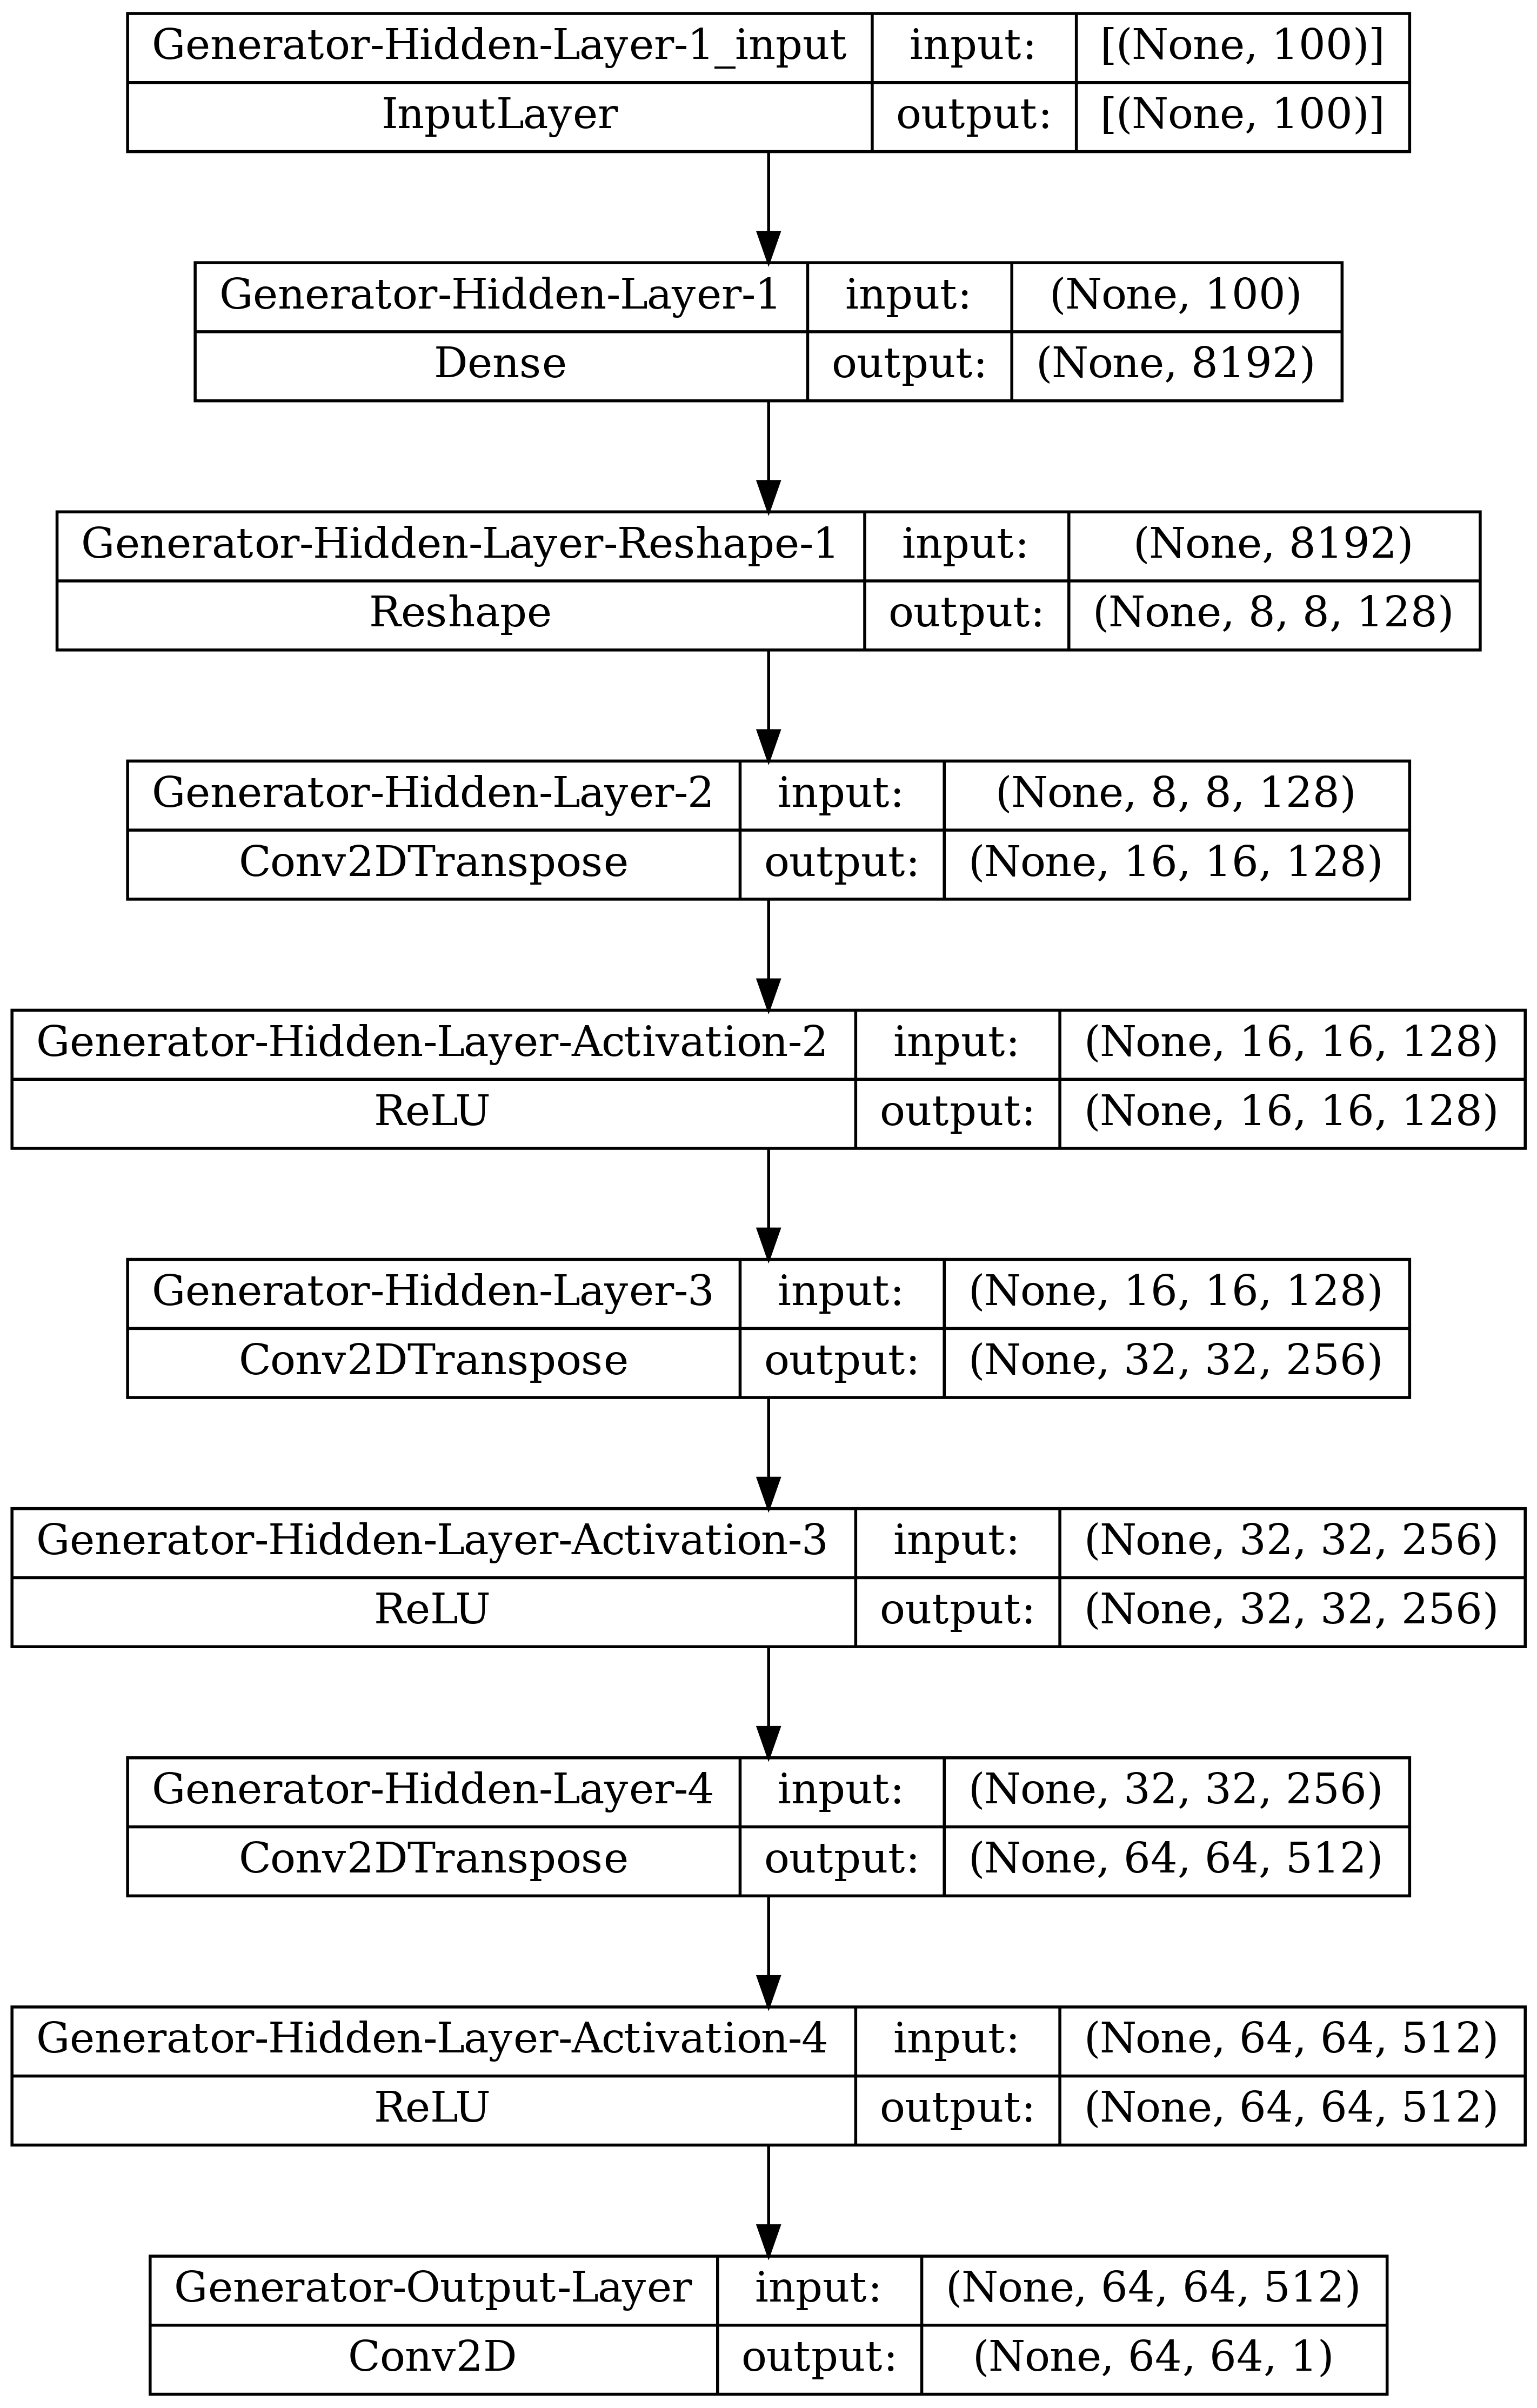

In [10]:
def generator(latent_dim):
    model = Sequential(name="Generator") # Model
    
    # Hidden Layer 1: Start with 8 x 8 image
    n_nodes = 8 * 8 * 128 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))
    model.add(Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))
    
    # Hidden Layer 2: Upsample to 16 x 16
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))
                              
    # Hidden Layer 3: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))
    
    # Hidden Layer 4: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))
    
    # Output Layer (Note, we use 3 filters because we have 3 channels for a color image. Grayscale would have only 1 channel)
    model.add(Conv2D(filters=1, kernel_size=(5,5), activation='tanh', padding='same', name='Generator-Output-Layer'))
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       1088      
 1 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       0         
 Activation-1 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      131200    
 2 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      0         
 Activation-2 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 8, 8, 128)      

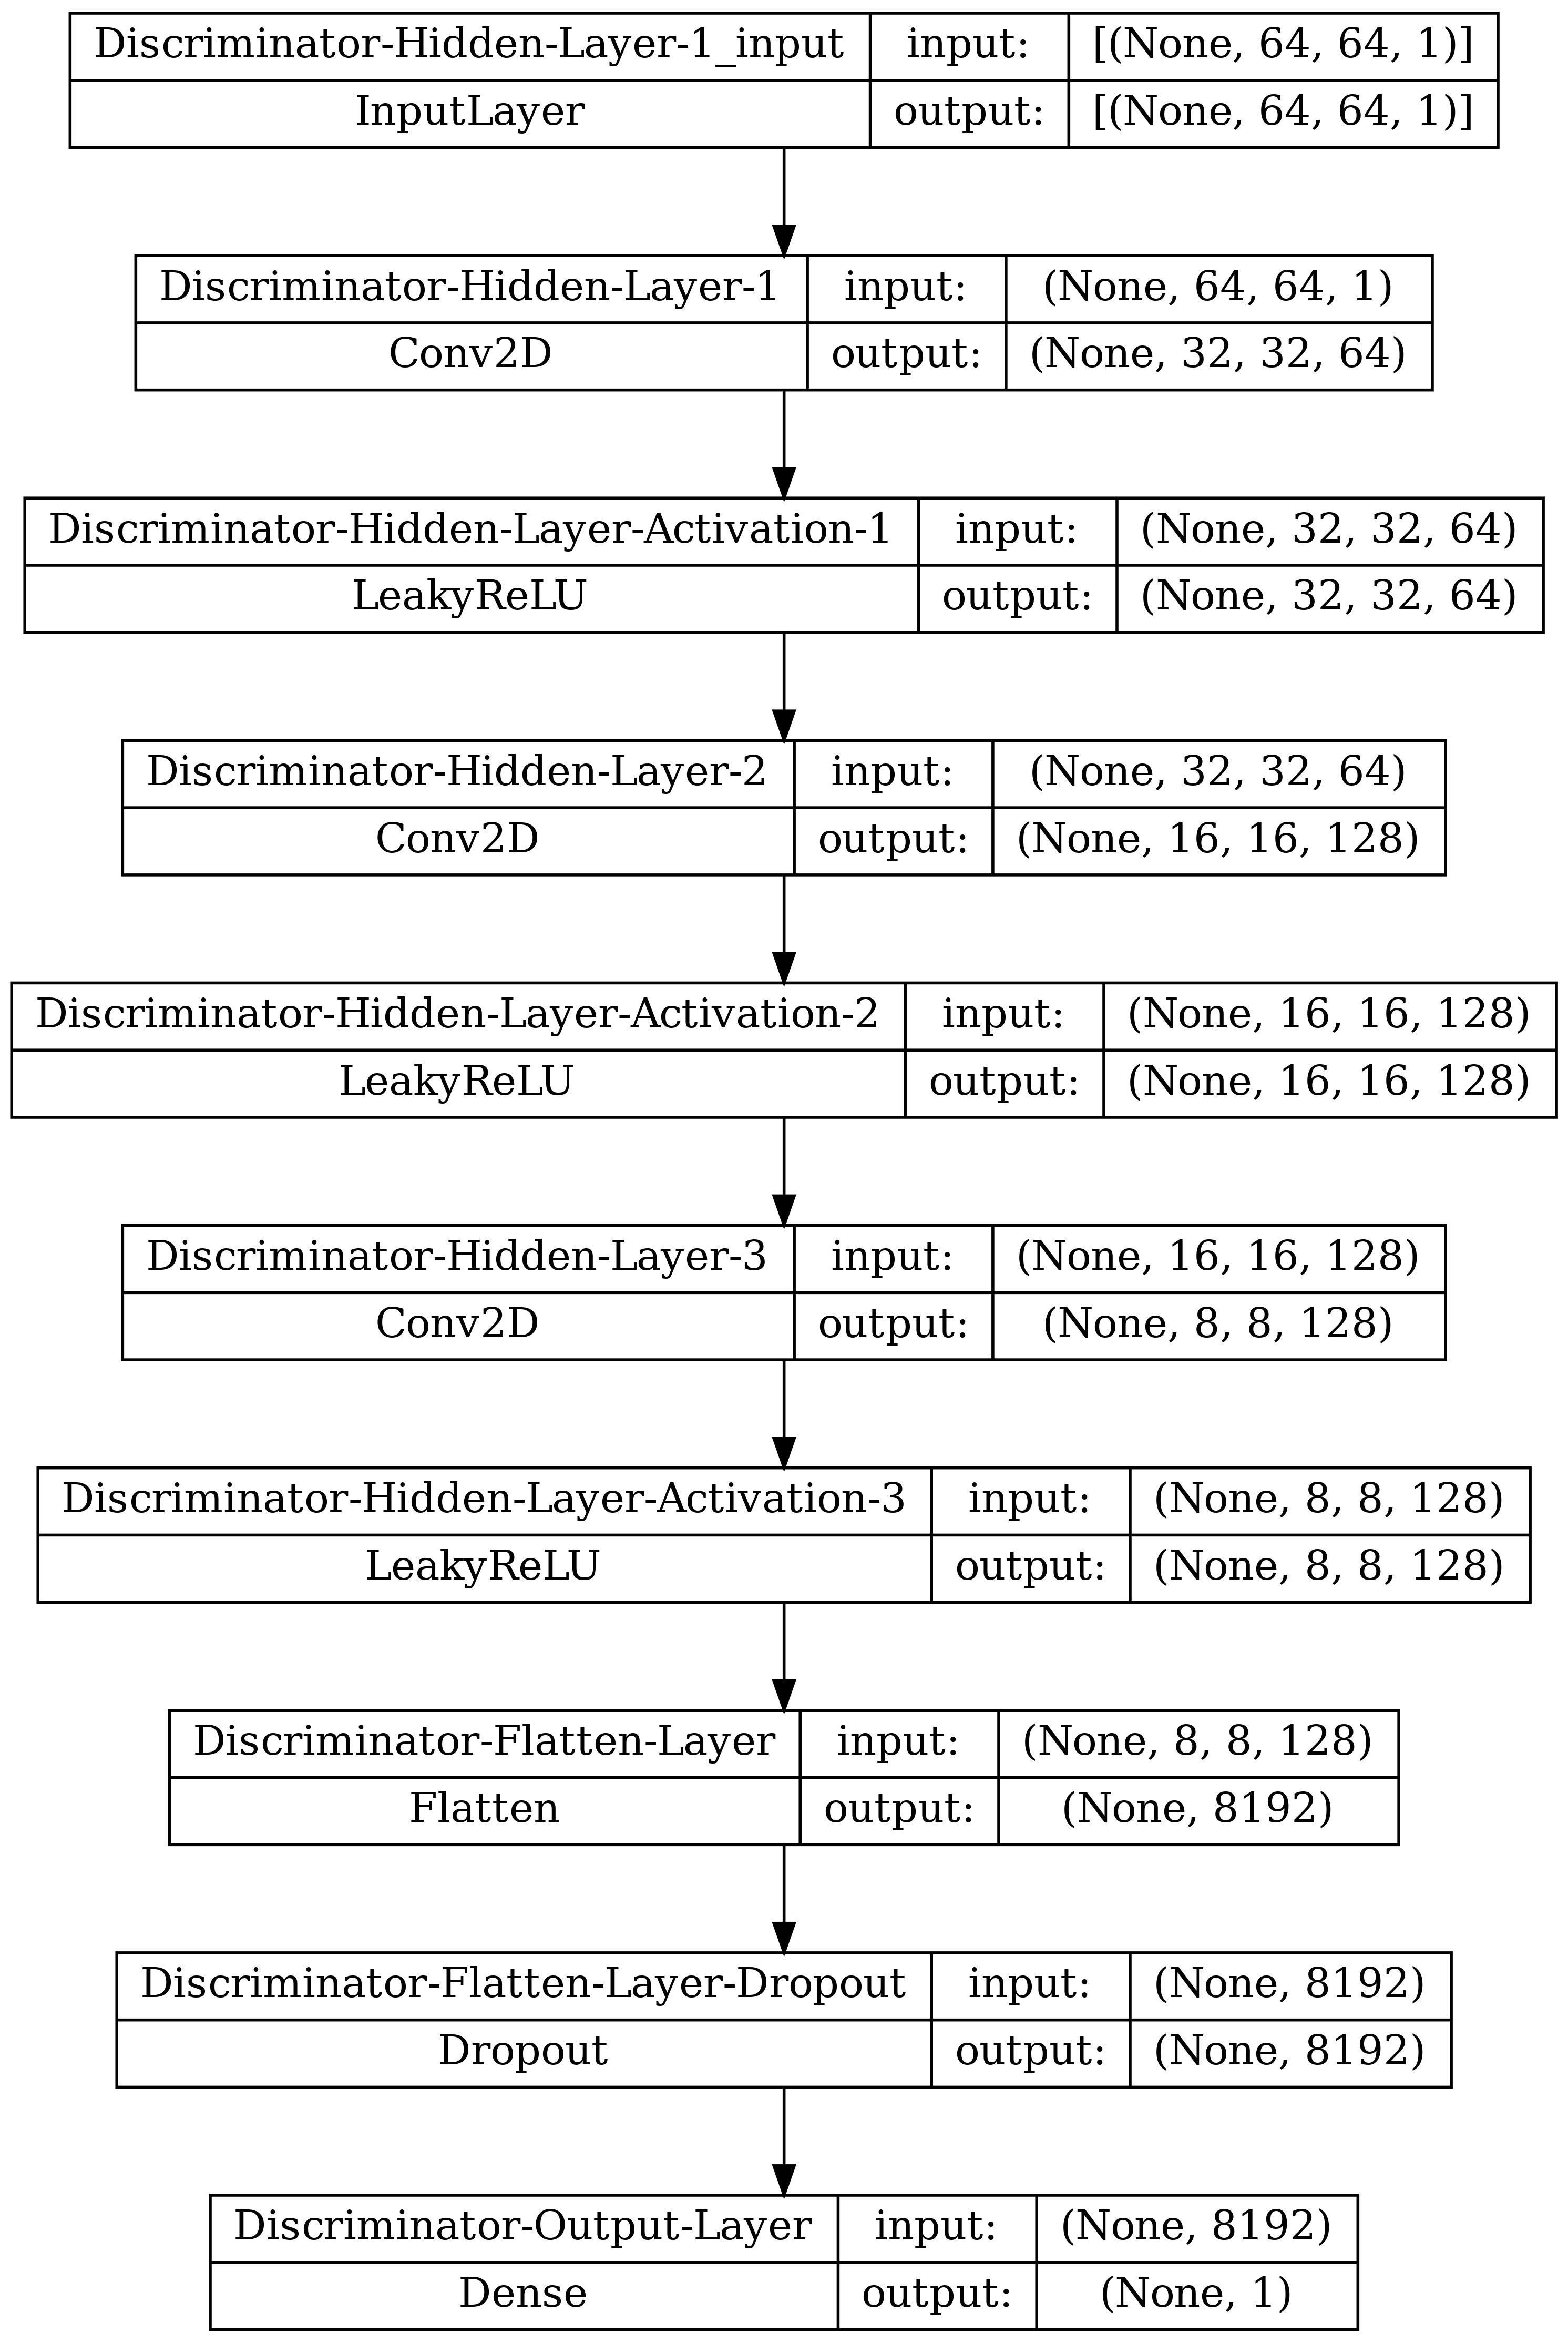

In [12]:
def discriminator(in_shape=(64,64,1)):
    model = Sequential(name="Discriminator") # Model
    
    # Hidden Layer 1
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    
    # Hidden Layer 2
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))
    
    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))
    
    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400)

Model: "DCGAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 1)         3724673   
                                                                 
 Discriminator (Sequential)  (None, 1)                 402753    
                                                                 
Total params: 4,127,426
Trainable params: 3,724,673
Non-trainable params: 402,753
_________________________________________________________________


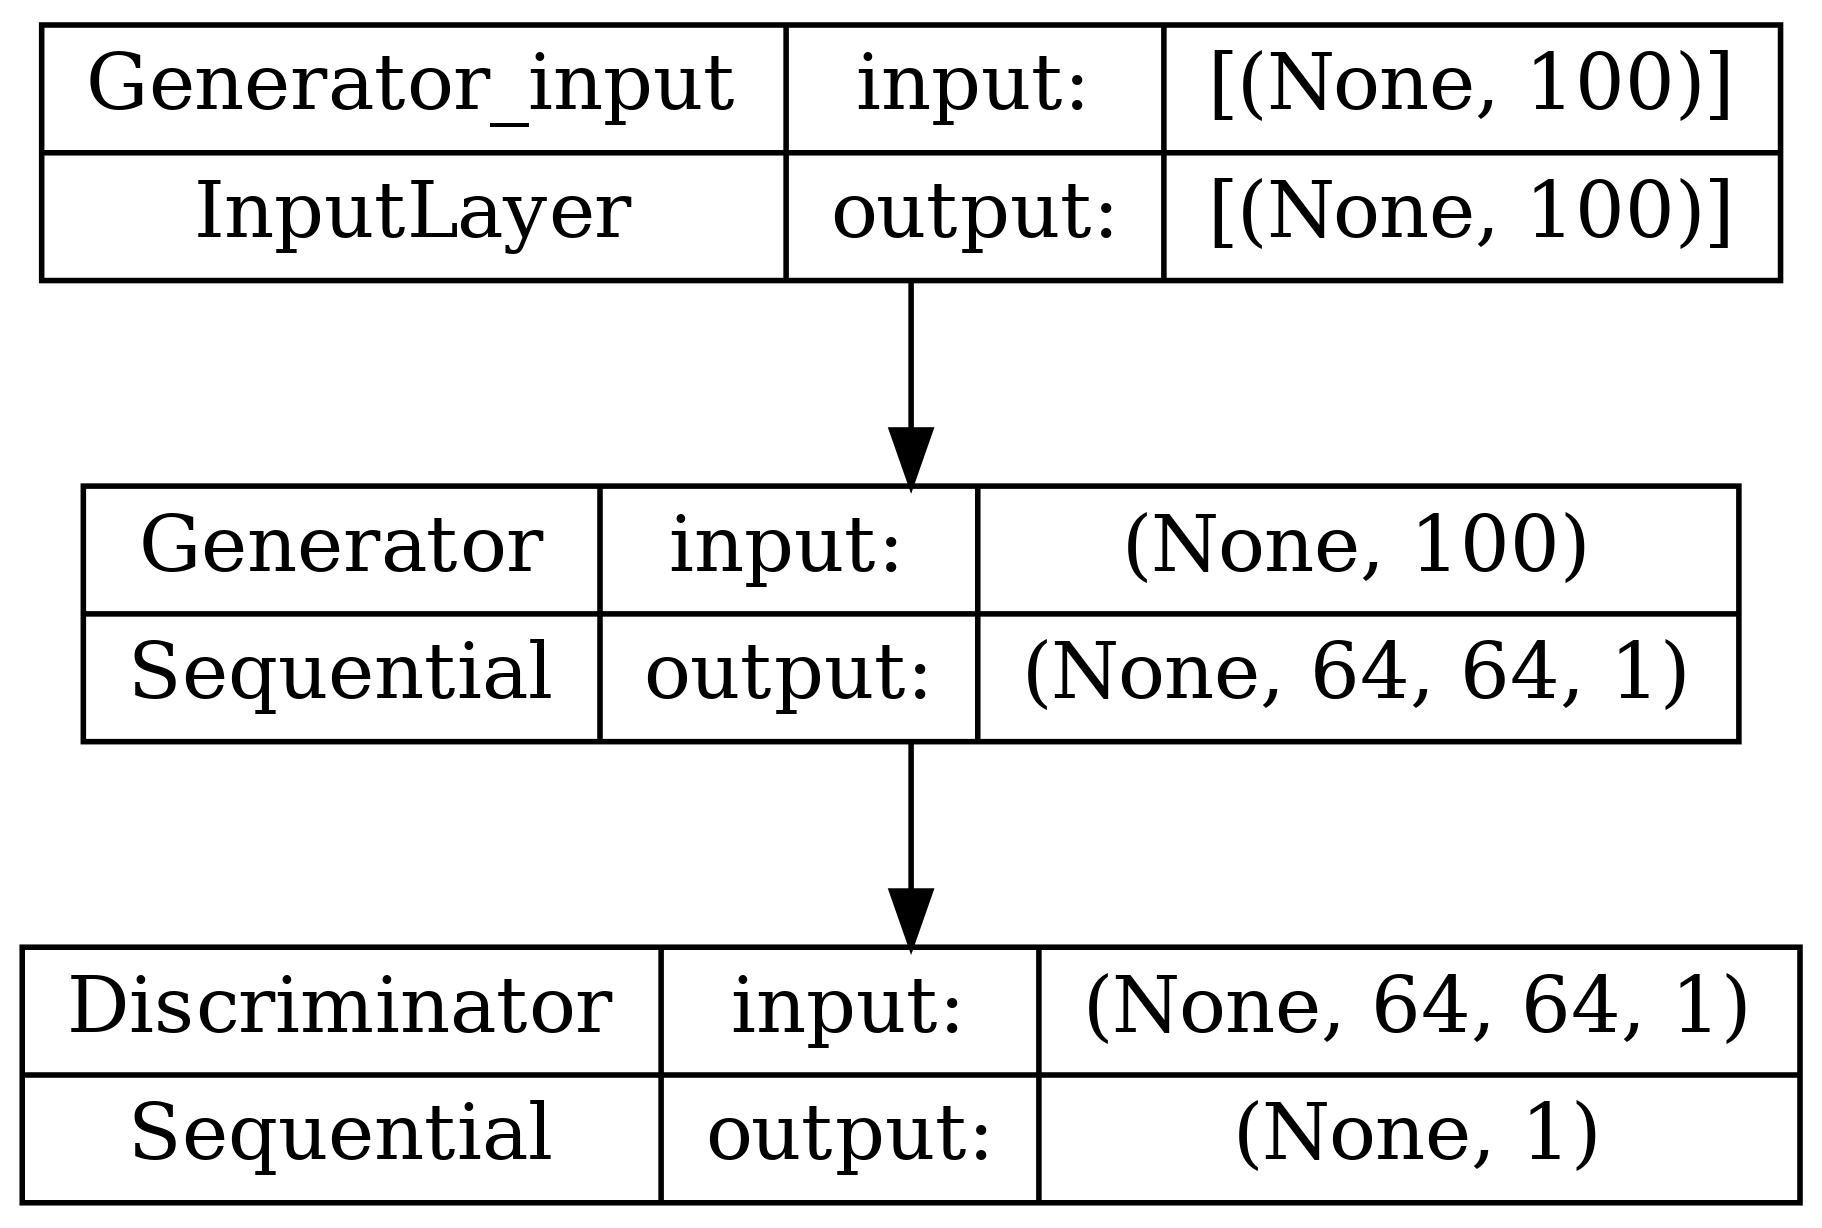

In [13]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Combine
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400)


In [14]:
def real_samples(n, dataset):
    
    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    return X, y
    
    
def latent_vector(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input
  
    
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X, y    

In [23]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 1)
    
    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].imshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 

In [26]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=3001, n_batch=32, n_eval=100):
    
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    
    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

1/1 [==============================] - 0s 22ms/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.48564666509628296
Generator Loss:  1.0859191417694092
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8999999761581421
Discriminator Accuracy on FAKE (generated) images:  0.800000011920929


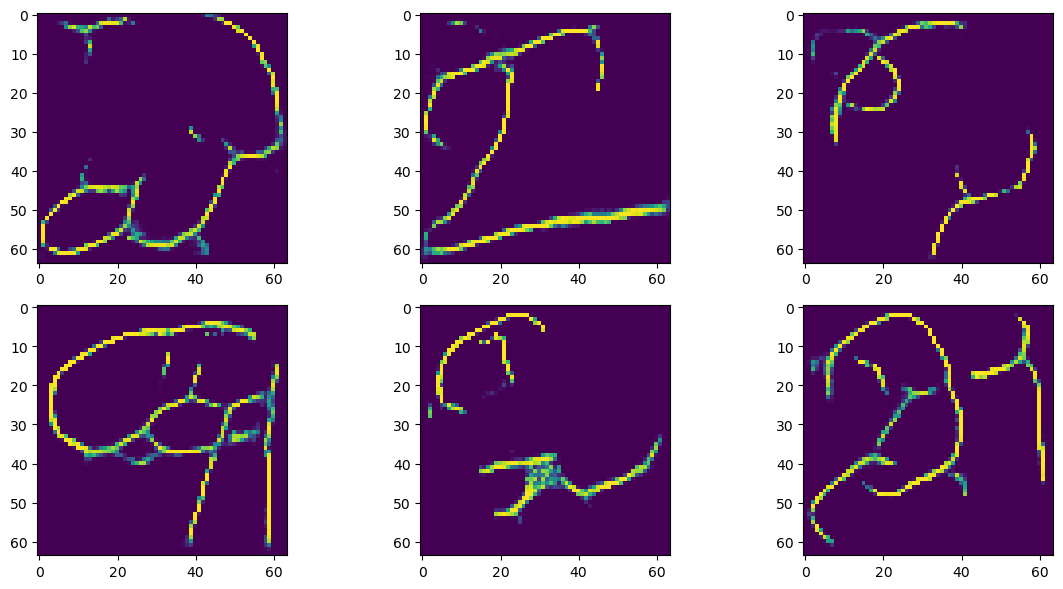

1/1 [==============================] - 0s 20ms/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.4616517424583435
Generator Loss:  0.9130817651748657
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9399999976158142
Discriminator Accuracy on FAKE (generated) images:  0.7599999904632568


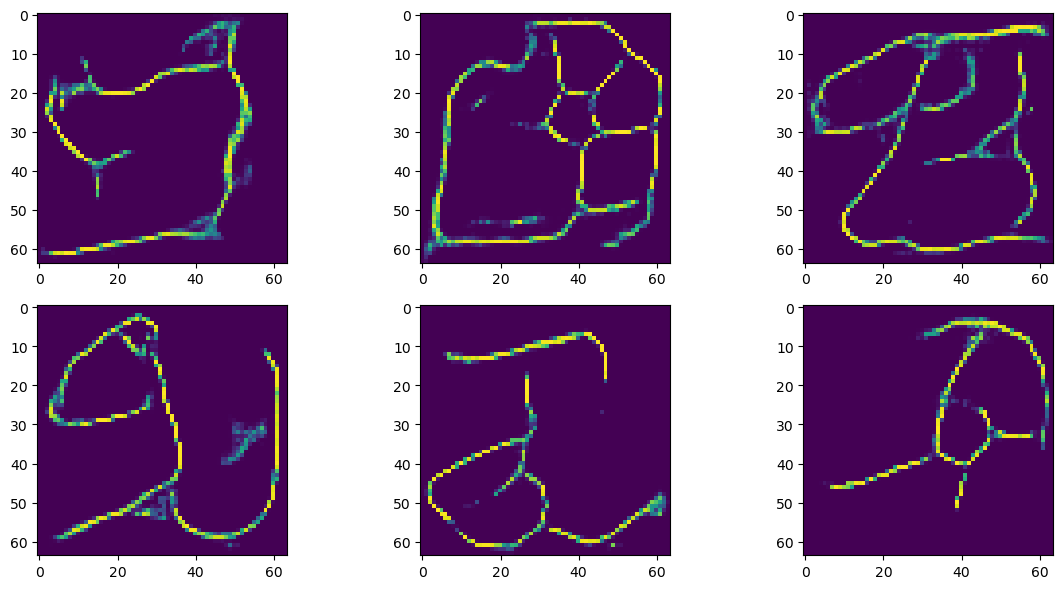

1/1 [==============================] - 0s 42ms/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.5559470057487488
Generator Loss:  1.1794579029083252
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.8199999928474426


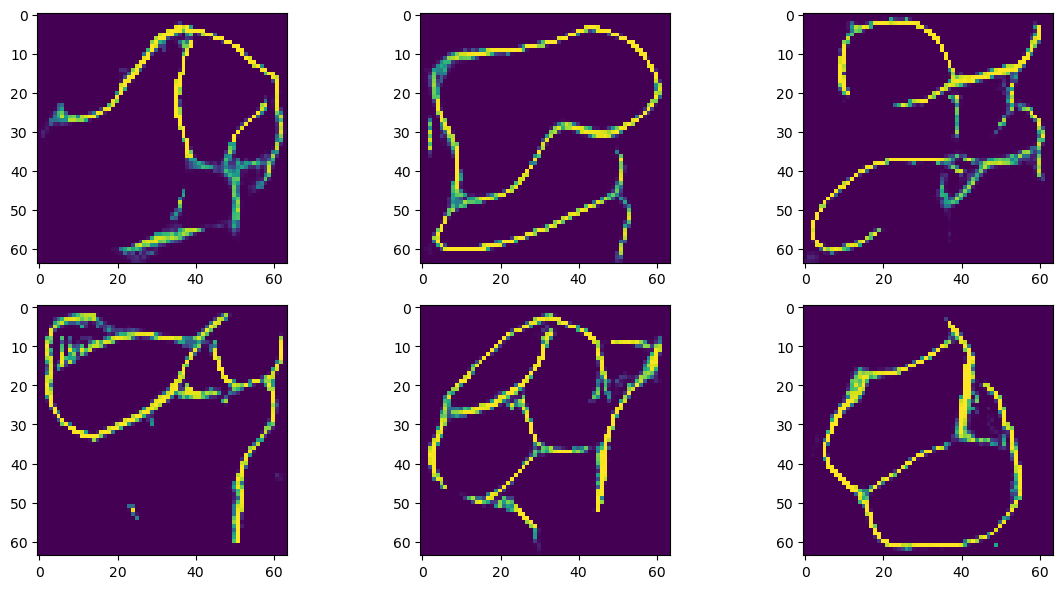

1/1 [==============================] - 0s 19ms/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.4247228801250458
Generator Loss:  1.0190284252166748
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.6600000262260437


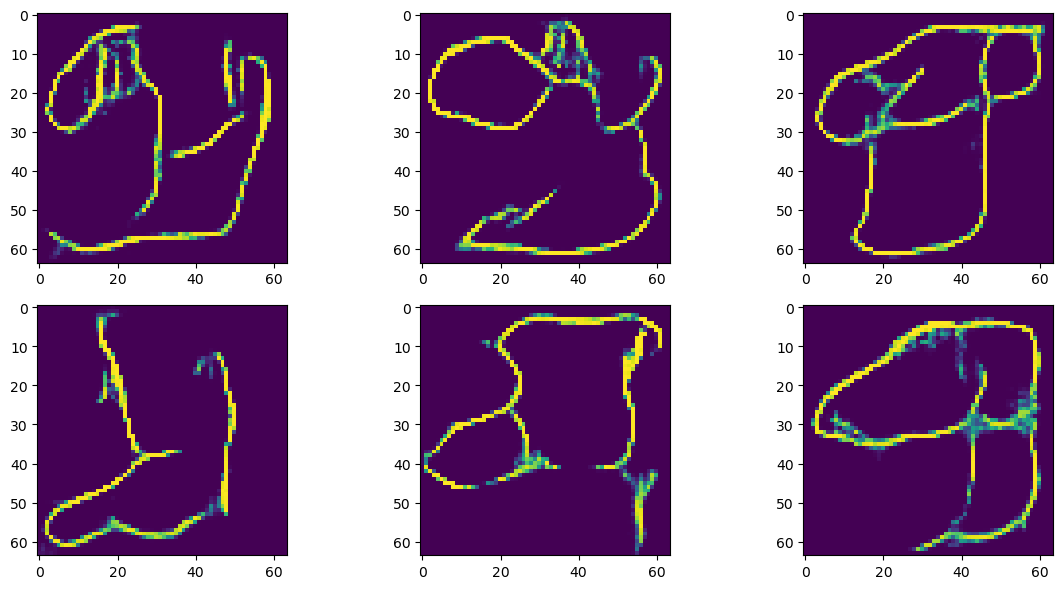

1/1 [==============================] - 0s 29ms/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.4875154197216034
Generator Loss:  1.507456660270691
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5199999809265137
Discriminator Accuracy on FAKE (generated) images:  1.0


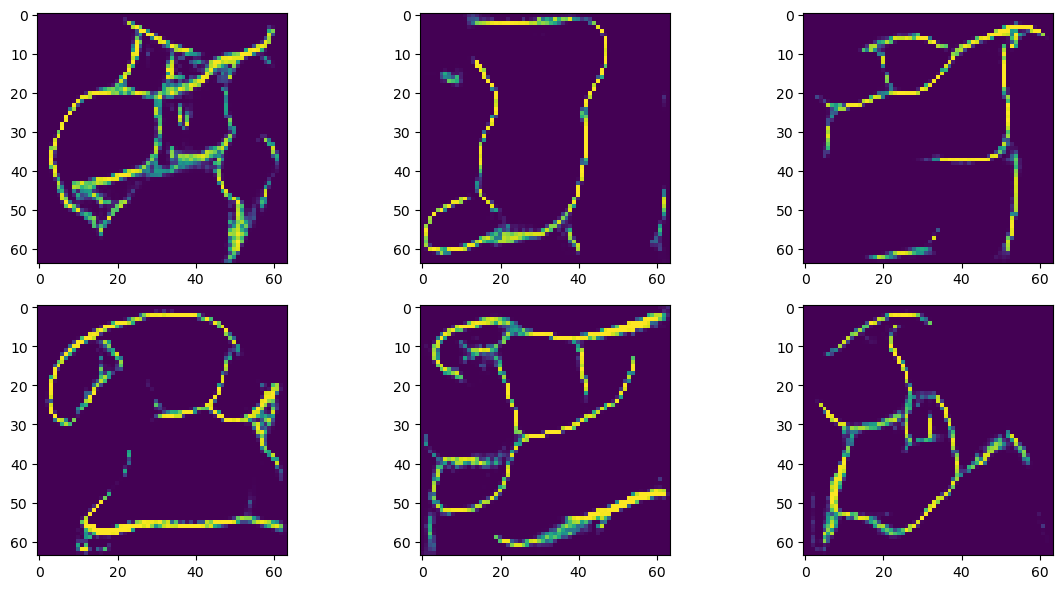

1/1 [==============================] - 0s 20ms/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.4569297730922699
Generator Loss:  1.1639482975006104
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9399999976158142
Discriminator Accuracy on FAKE (generated) images:  0.6399999856948853


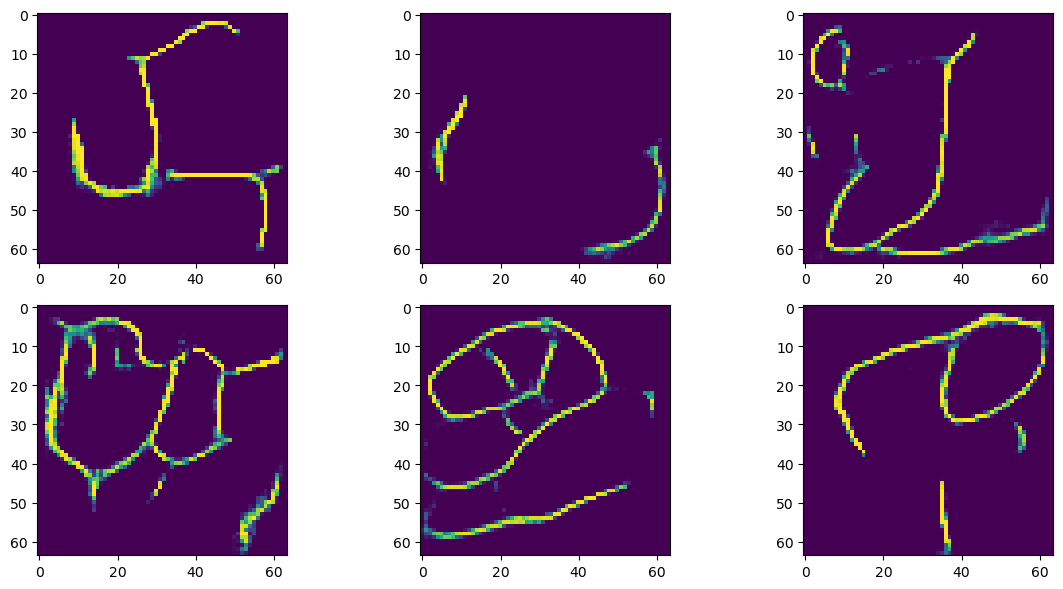

1/1 [==============================] - 0s 21ms/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.4829634428024292
Generator Loss:  1.7717310190200806
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5799999833106995
Discriminator Accuracy on FAKE (generated) images:  1.0


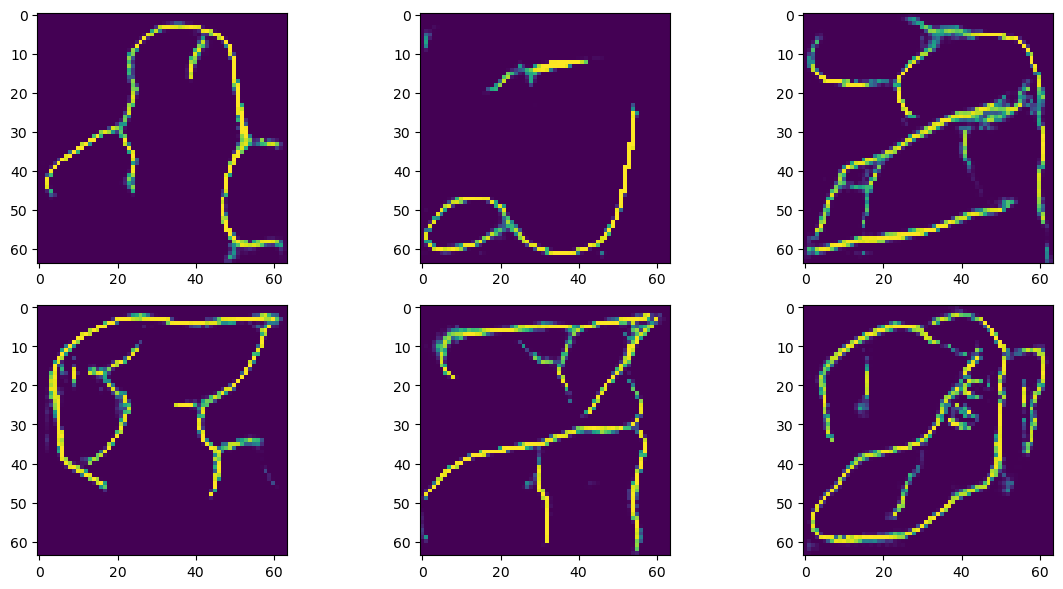

1/1 [==============================] - 0s 19ms/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.4743625819683075
Generator Loss:  1.0229542255401611
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) images:  0.8600000143051147


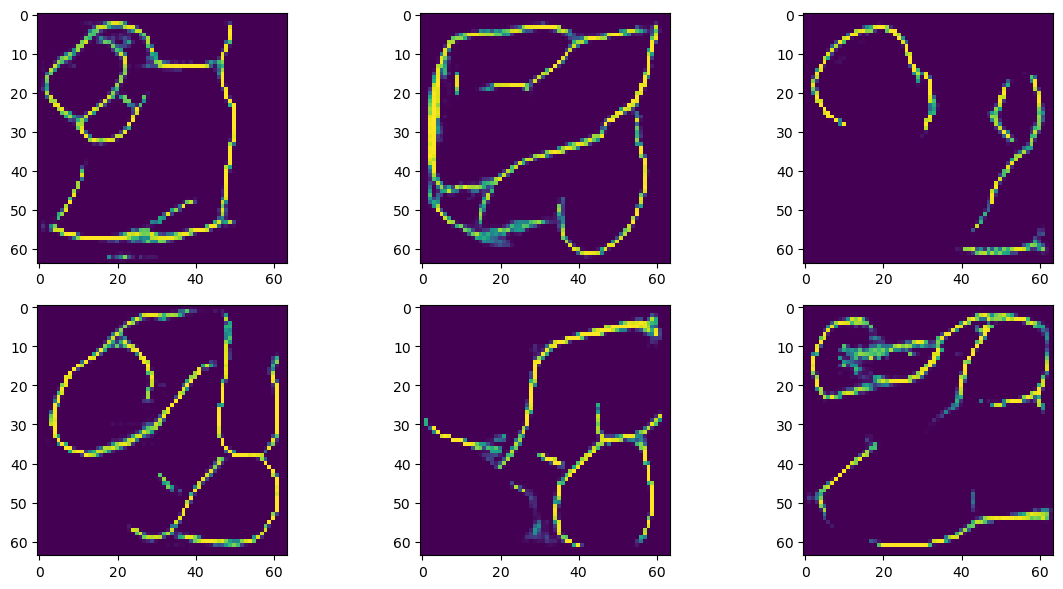

1/1 [==============================] - 0s 19ms/step
Epoch number:  800
*** Training ***
Discriminator Loss  1.309159517288208
Generator Loss:  1.2614550590515137
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) images:  0.6800000071525574


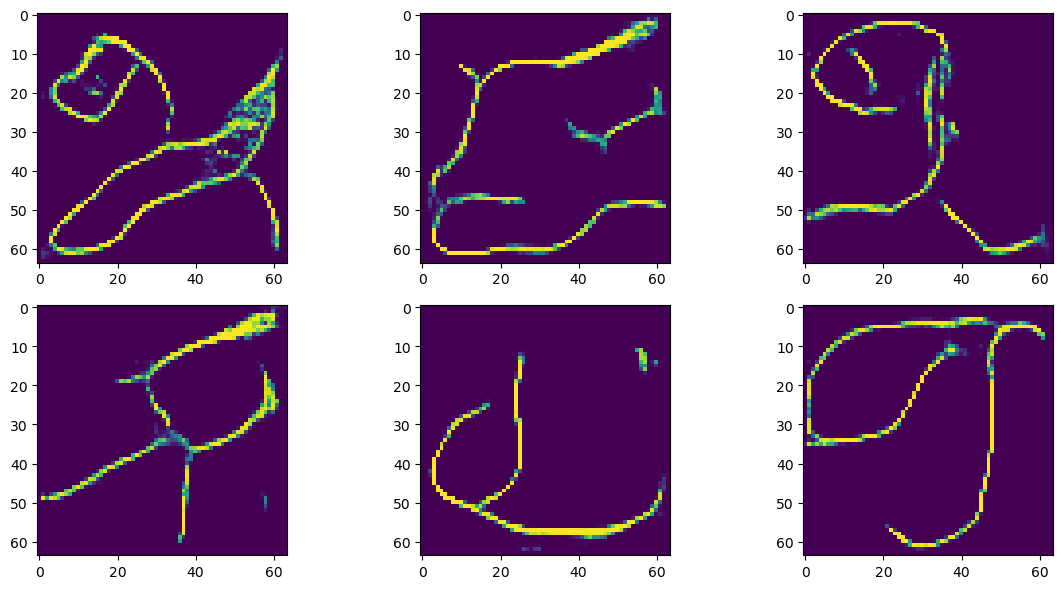

1/1 [==============================] - 0s 20ms/step
Epoch number:  900
*** Training ***
Discriminator Loss  0.5139704942703247
Generator Loss:  1.1750112771987915
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9200000166893005
Discriminator Accuracy on FAKE (generated) images:  0.8600000143051147


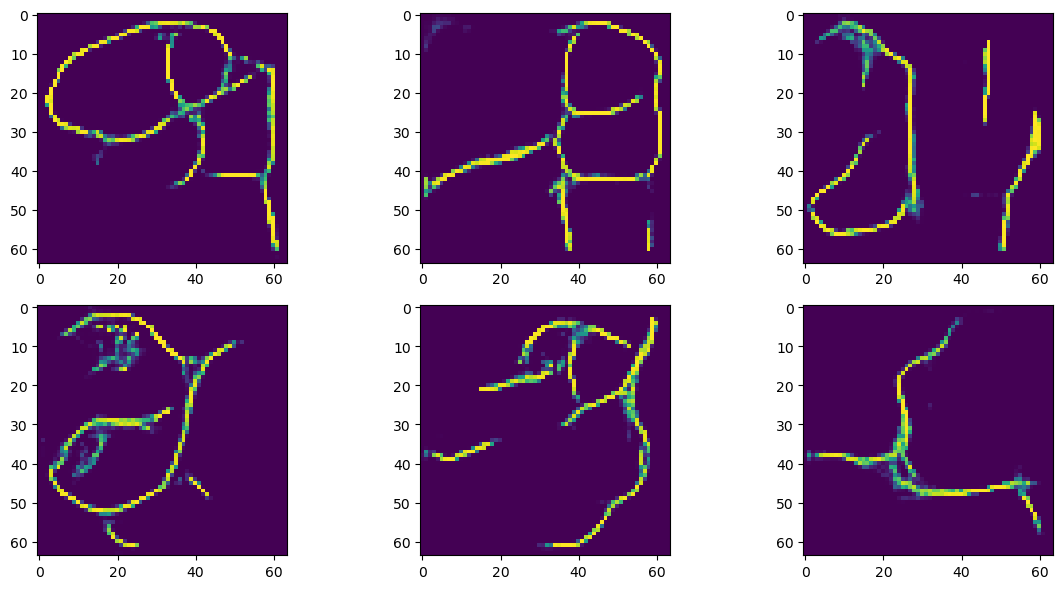

1/1 [==============================] - 0s 19ms/step
Epoch number:  1000
*** Training ***
Discriminator Loss  0.45987945795059204
Generator Loss:  0.8668069839477539
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9599999785423279
Discriminator Accuracy on FAKE (generated) images:  0.7200000286102295


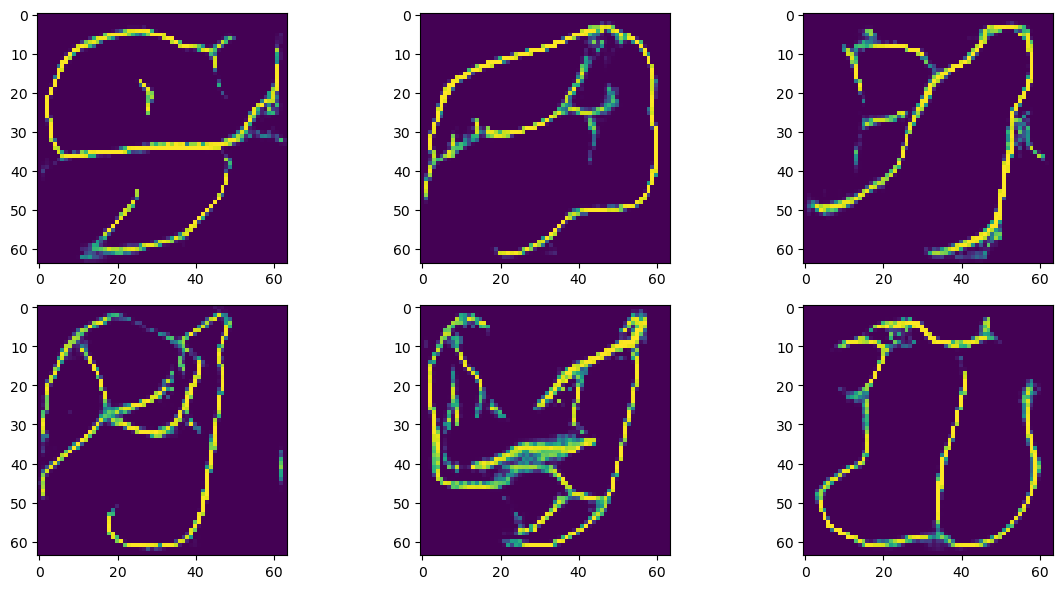

1/1 [==============================] - 0s 20ms/step
Epoch number:  1100
*** Training ***
Discriminator Loss  0.46858006715774536
Generator Loss:  1.026341438293457
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9599999785423279
Discriminator Accuracy on FAKE (generated) images:  0.699999988079071


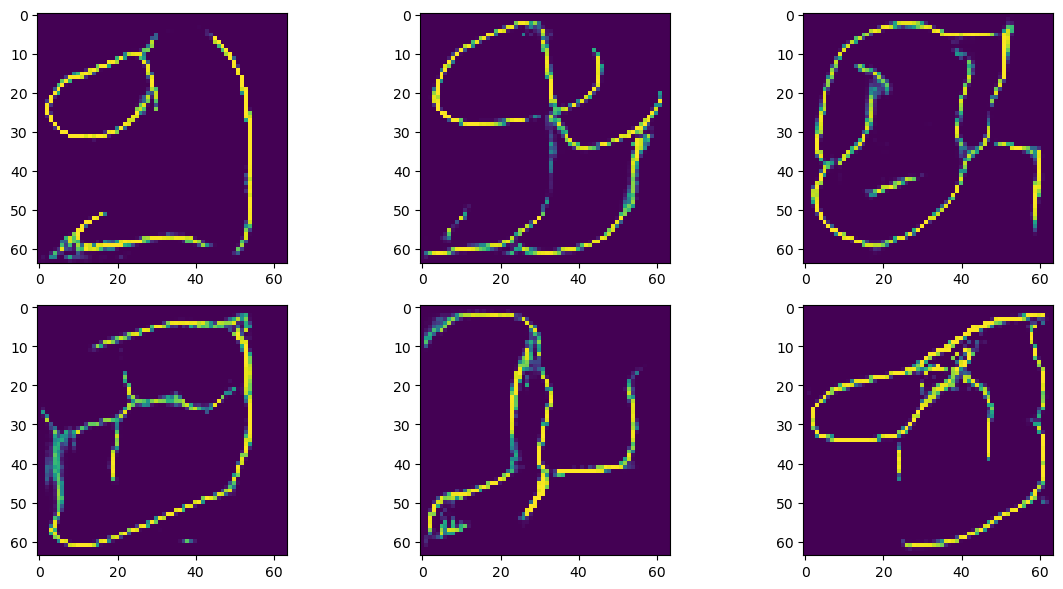

1/1 [==============================] - 0s 20ms/step
Epoch number:  1200
*** Training ***
Discriminator Loss  0.5819769501686096
Generator Loss:  0.9416706562042236
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.5400000214576721


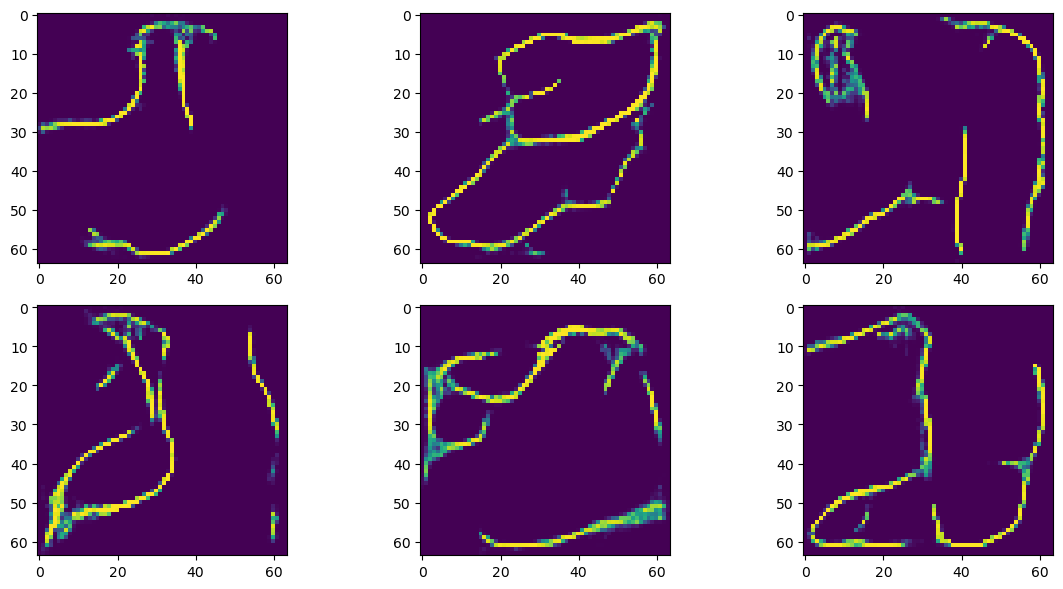

1/1 [==============================] - 0s 21ms/step
Epoch number:  1300
*** Training ***
Discriminator Loss  0.5491793155670166
Generator Loss:  1.0600860118865967
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8399999737739563
Discriminator Accuracy on FAKE (generated) images:  0.6000000238418579


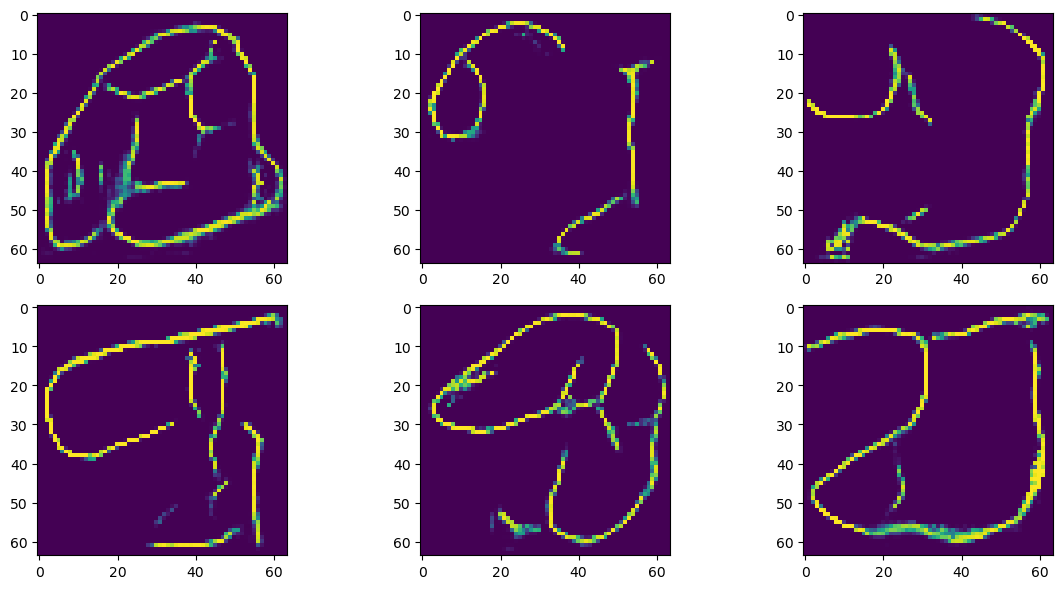

1/1 [==============================] - 0s 20ms/step
Epoch number:  1400
*** Training ***
Discriminator Loss  0.43213412165641785
Generator Loss:  1.6473047733306885
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.800000011920929
Discriminator Accuracy on FAKE (generated) images:  0.8799999952316284


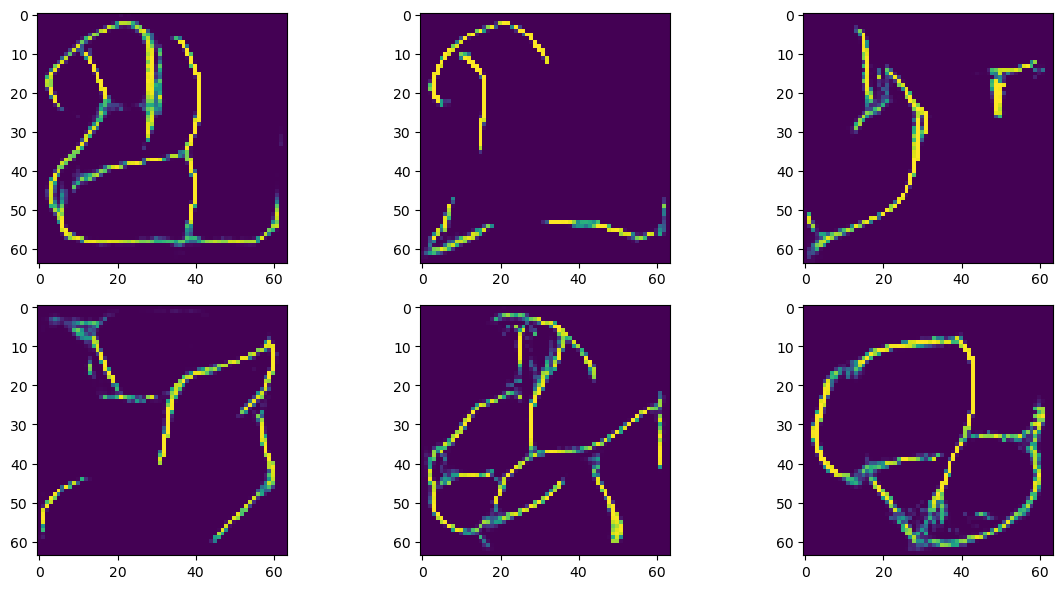

1/1 [==============================] - 0s 19ms/step
Epoch number:  1500
*** Training ***
Discriminator Loss  0.37204688787460327
Generator Loss:  0.924567461013794
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9800000190734863
Discriminator Accuracy on FAKE (generated) images:  0.41999998688697815


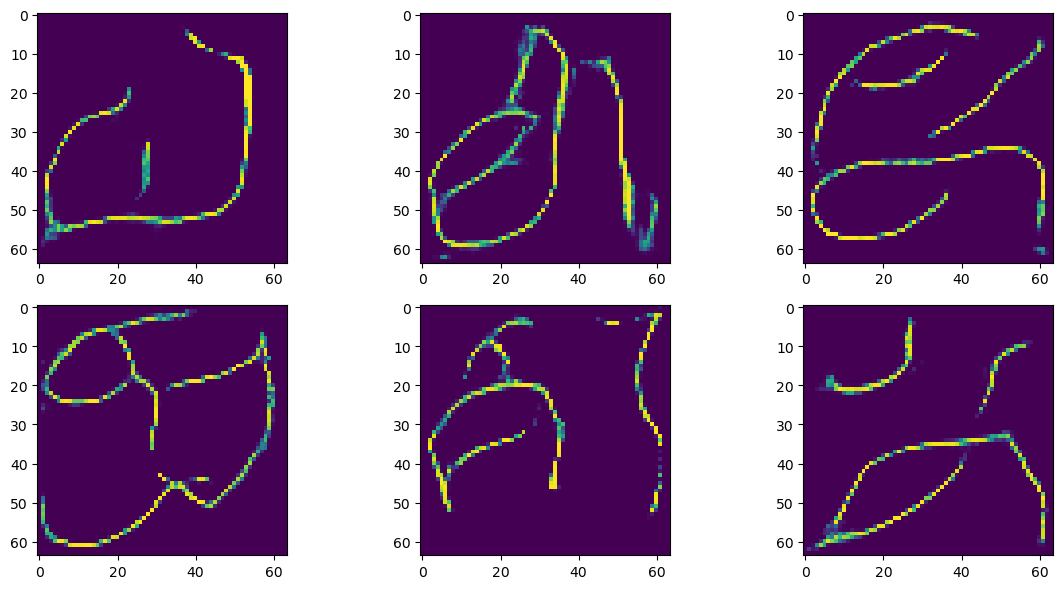

1/1 [==============================] - 0s 19ms/step
Epoch number:  1600
*** Training ***
Discriminator Loss  0.5846374034881592
Generator Loss:  1.666381597518921
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7400000095367432
Discriminator Accuracy on FAKE (generated) images:  0.8799999952316284


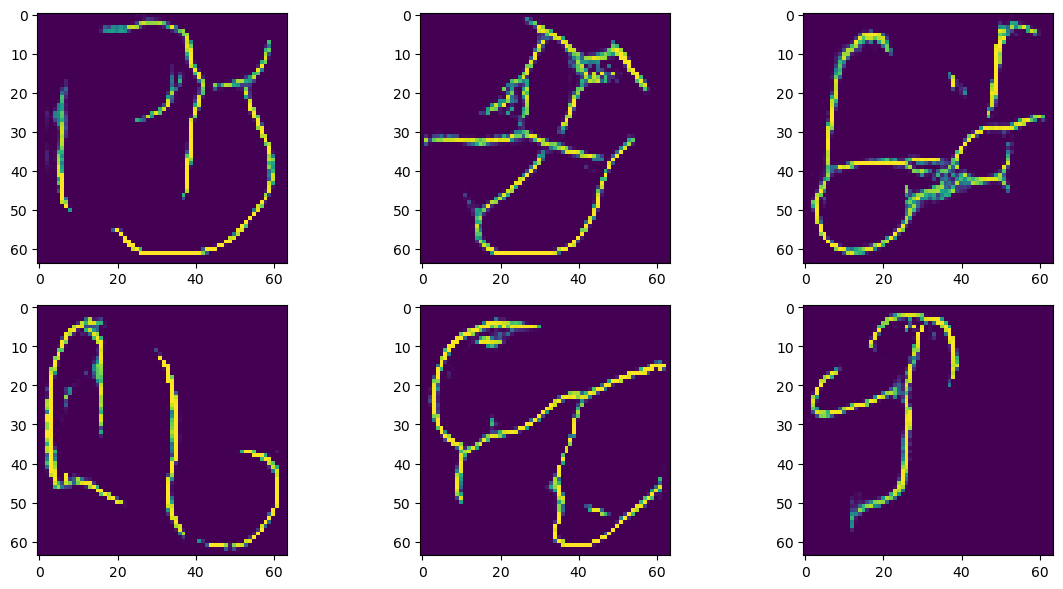

1/1 [==============================] - 0s 19ms/step
Epoch number:  1700
*** Training ***
Discriminator Loss  0.6021603345870972
Generator Loss:  2.2181143760681152
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


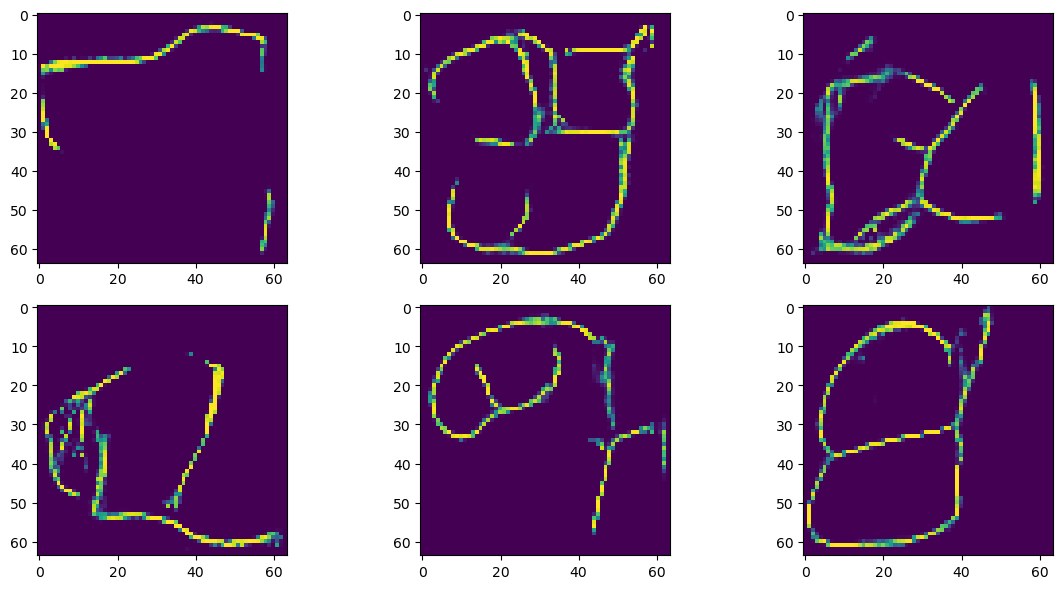

1/1 [==============================] - 0s 21ms/step
Epoch number:  1800
*** Training ***
Discriminator Loss  0.5061755180358887
Generator Loss:  1.4905110597610474
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.8799999952316284


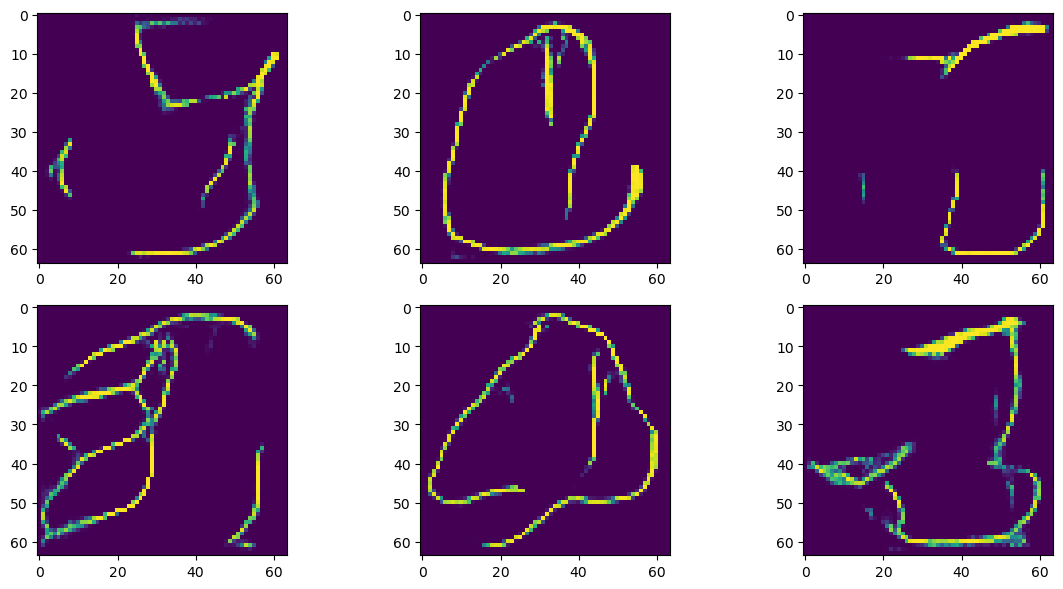

1/1 [==============================] - 0s 22ms/step
Epoch number:  1900
*** Training ***
Discriminator Loss  0.34917354583740234
Generator Loss:  1.7469351291656494
2/2 [==============================] - 0s 30ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.699999988079071
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


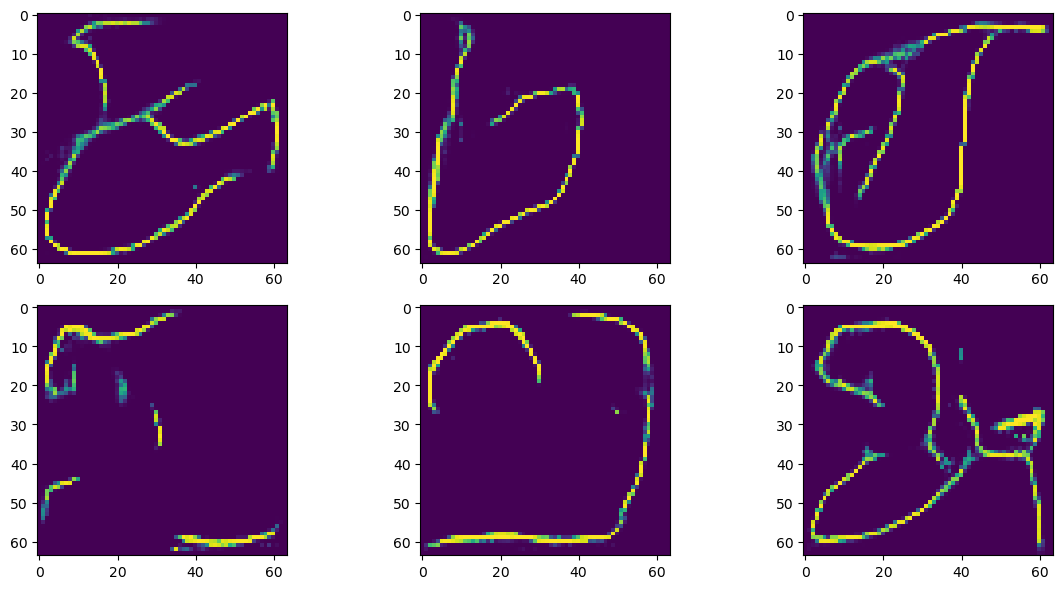

1/1 [==============================] - 0s 19ms/step
Epoch number:  2000
*** Training ***
Discriminator Loss  0.49472346901893616
Generator Loss:  1.9506657123565674
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6000000238418579
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


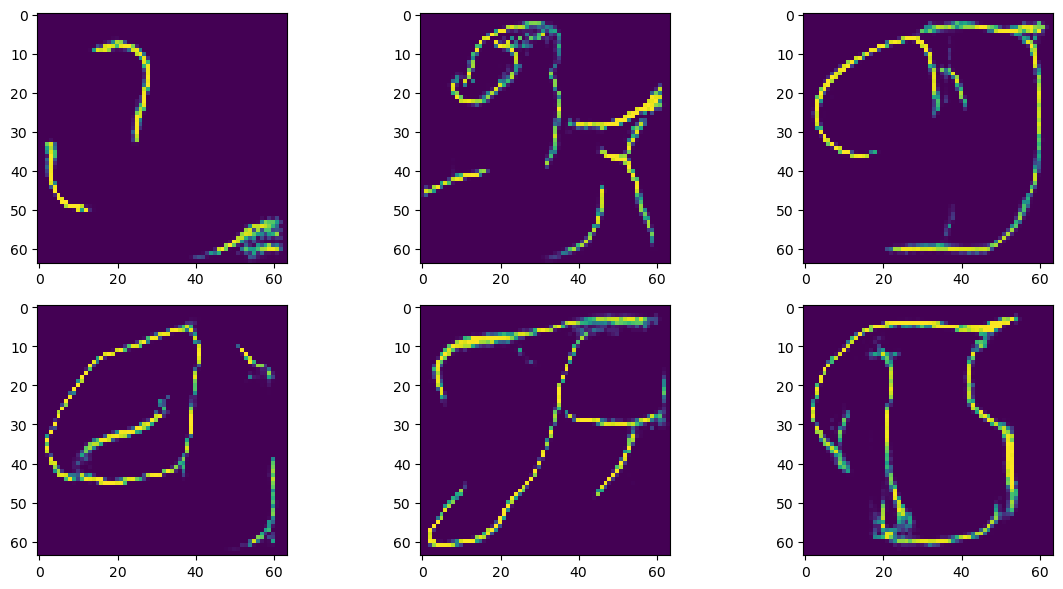

1/1 [==============================] - 0s 18ms/step
Epoch number:  2100
*** Training ***
Discriminator Loss  0.459022581577301
Generator Loss:  1.718498945236206
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6399999856948853
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


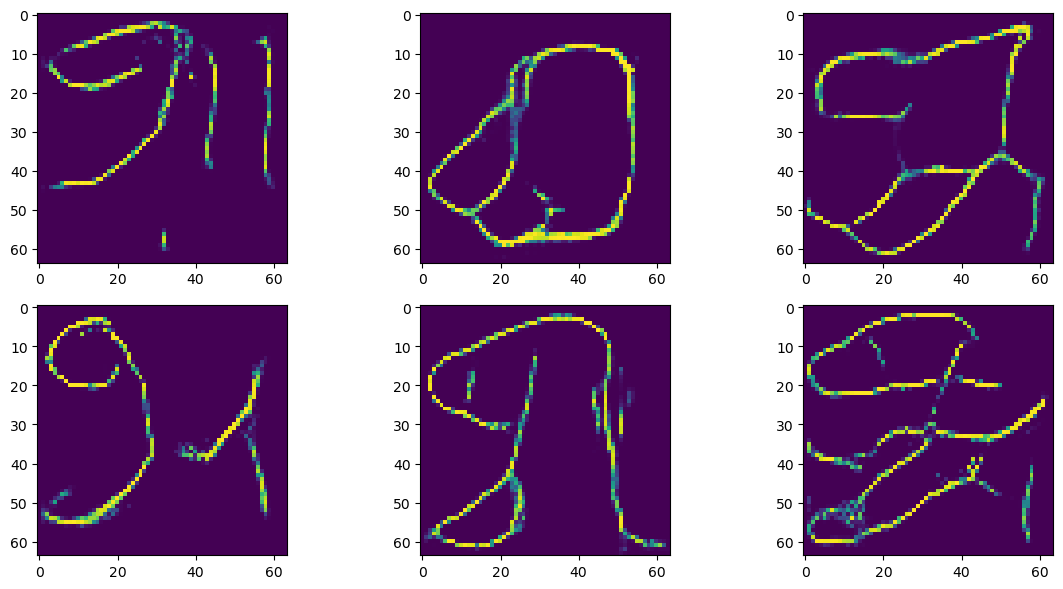

1/1 [==============================] - 0s 19ms/step
Epoch number:  2200
*** Training ***
Discriminator Loss  0.6275068521499634
Generator Loss:  2.46337890625
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.3400000035762787
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


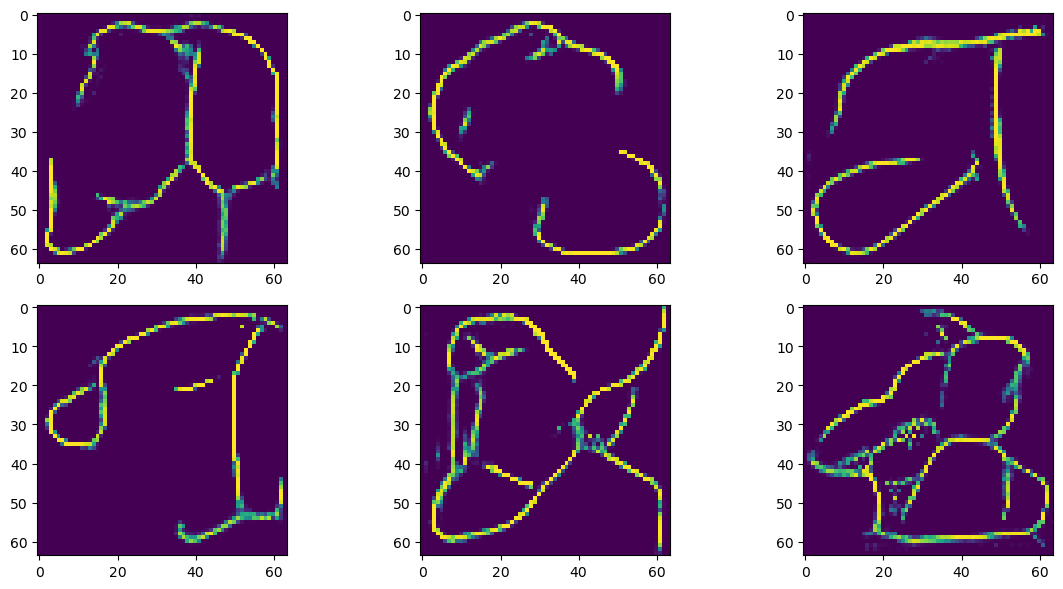

1/1 [==============================] - 0s 19ms/step
Epoch number:  2300
*** Training ***
Discriminator Loss  0.5561779737472534
Generator Loss:  1.2910082340240479
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.8799999952316284


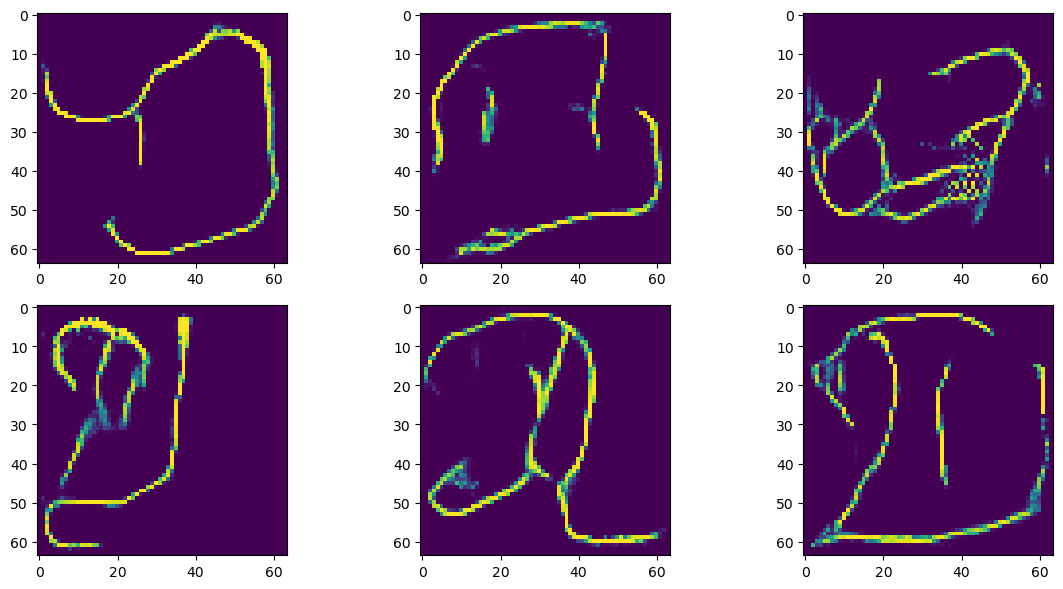

1/1 [==============================] - 0s 19ms/step
Epoch number:  2400
*** Training ***
Discriminator Loss  0.5020008087158203
Generator Loss:  1.6021379232406616
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6000000238418579
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


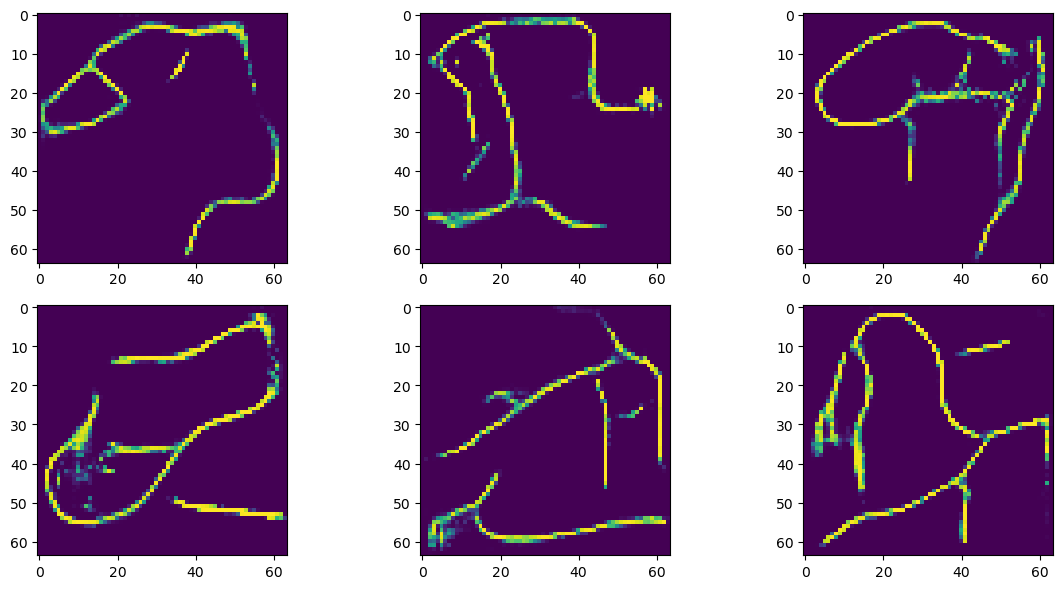

1/1 [==============================] - 0s 19ms/step
Epoch number:  2500
*** Training ***
Discriminator Loss  0.5584789514541626
Generator Loss:  1.5101758241653442
2/2 [==============================] - 0s 32ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7200000286102295
Discriminator Accuracy on FAKE (generated) images:  0.9200000166893005


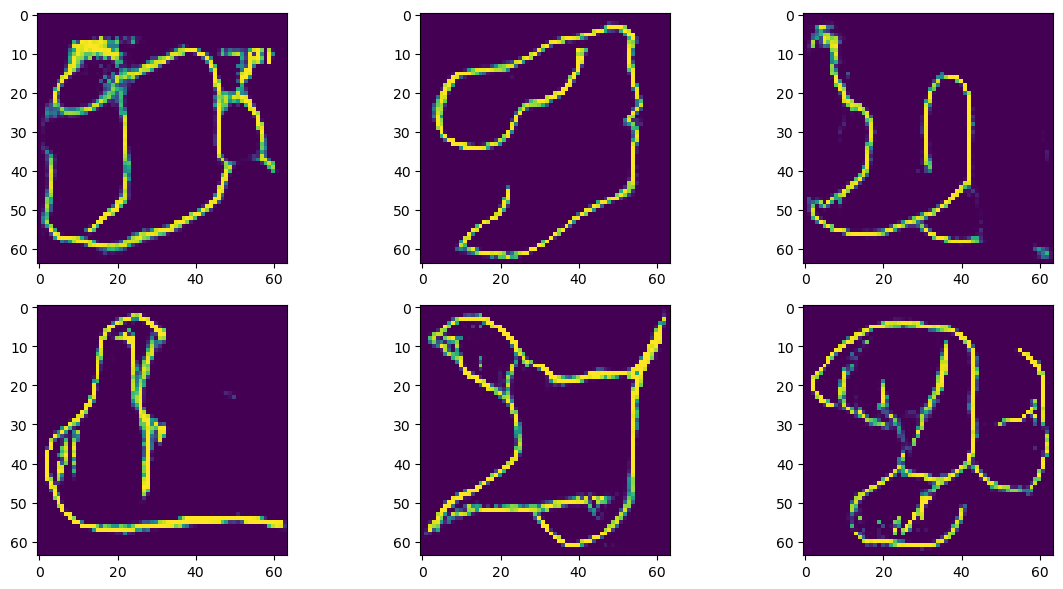

1/1 [==============================] - 0s 20ms/step
Epoch number:  2600
*** Training ***
Discriminator Loss  0.5512726306915283
Generator Loss:  1.022775650024414
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9399999976158142
Discriminator Accuracy on FAKE (generated) images:  0.7799999713897705


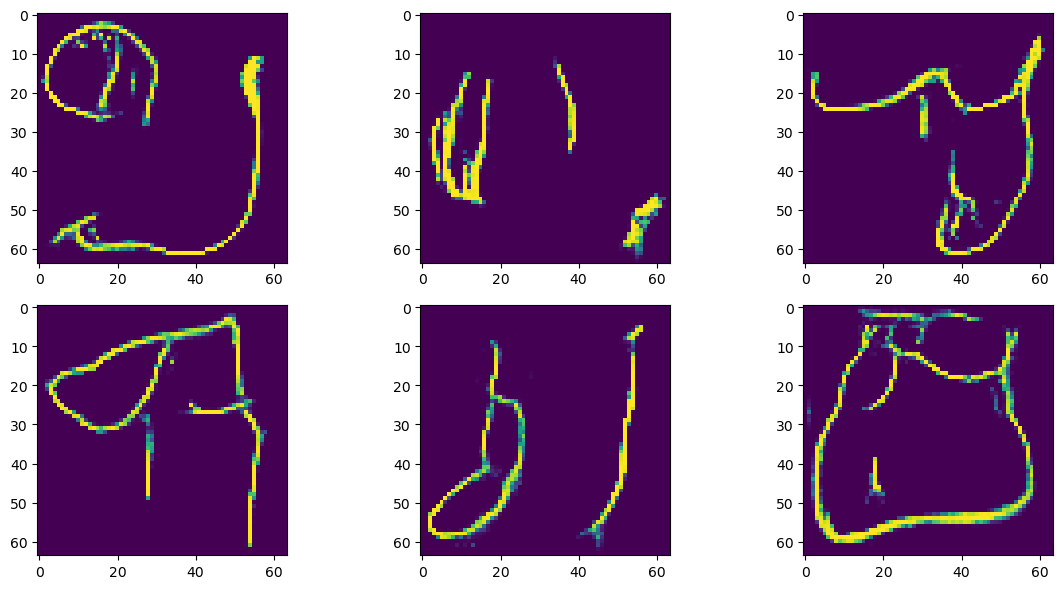

1/1 [==============================] - 0s 21ms/step
Epoch number:  2700
*** Training ***
Discriminator Loss  0.6295267343521118
Generator Loss:  1.089861273765564
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8999999761581421
Discriminator Accuracy on FAKE (generated) images:  0.7599999904632568


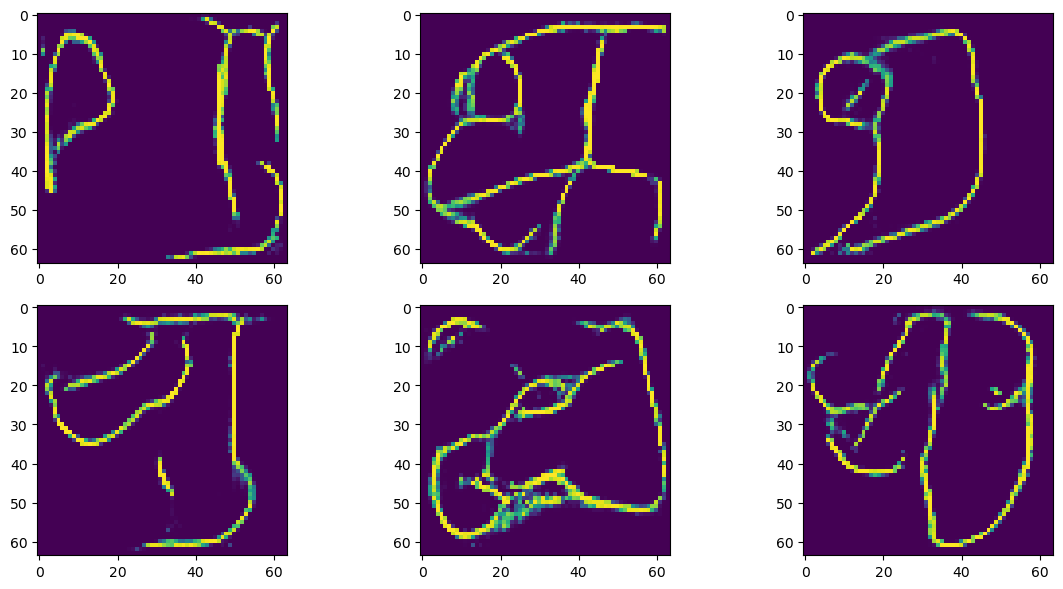

1/1 [==============================] - 0s 19ms/step
Epoch number:  2800
*** Training ***
Discriminator Loss  0.46777477860450745
Generator Loss:  1.1656882762908936
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9599999785423279
Discriminator Accuracy on FAKE (generated) images:  0.7599999904632568


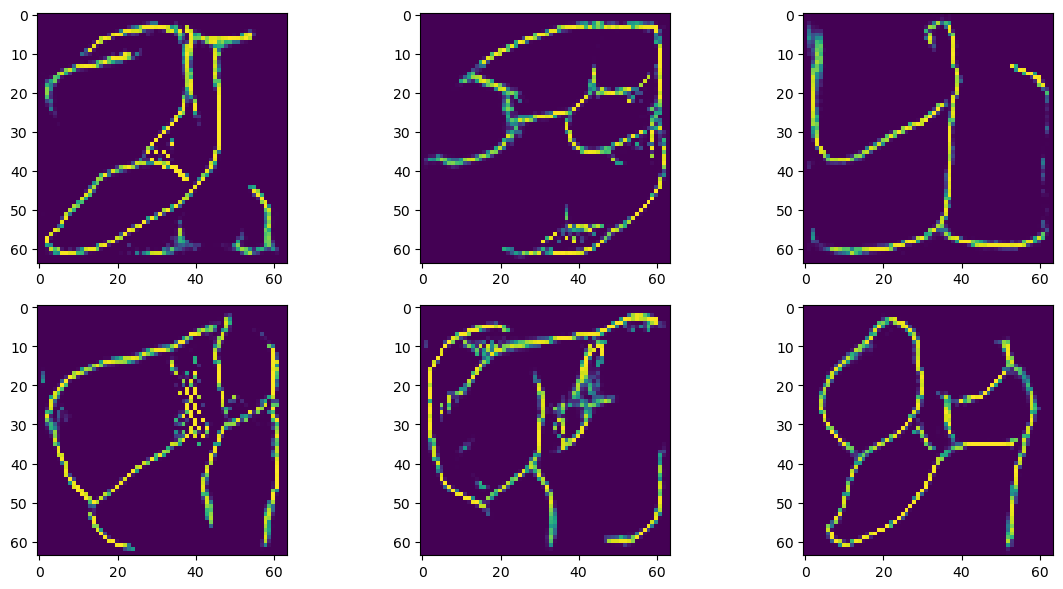

1/1 [==============================] - 0s 19ms/step
Epoch number:  2900
*** Training ***
Discriminator Loss  0.47069042921066284
Generator Loss:  1.6774916648864746
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7200000286102295
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


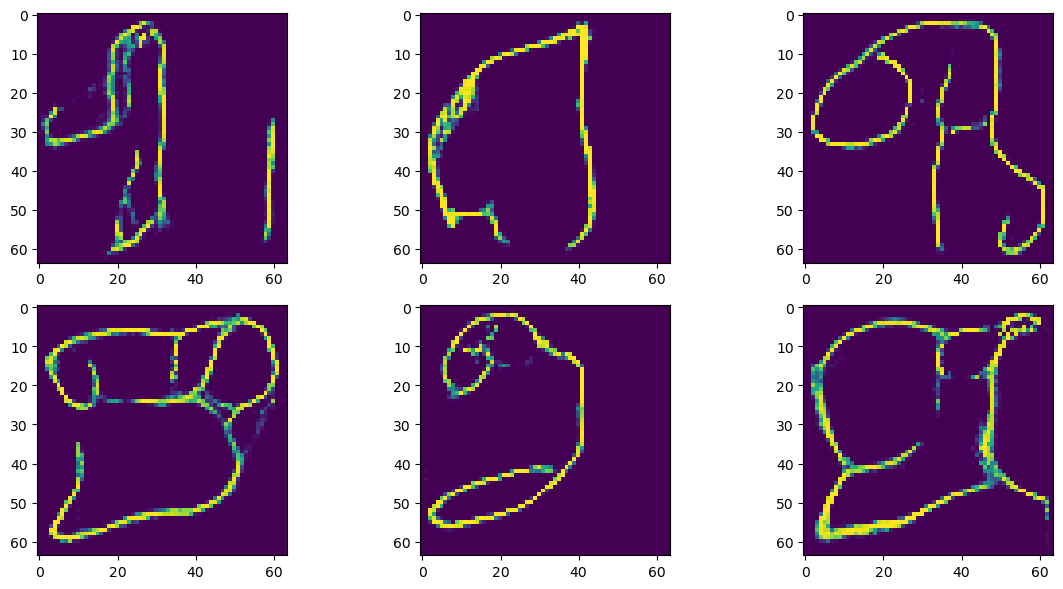

1/1 [==============================] - 0s 20ms/step
Epoch number:  3000
*** Training ***
Discriminator Loss  0.4800484776496887
Generator Loss:  0.9637457728385925
2/2 [==============================] - 0s 31ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9399999976158142
Discriminator Accuracy on FAKE (generated) images:  0.7799999713897705


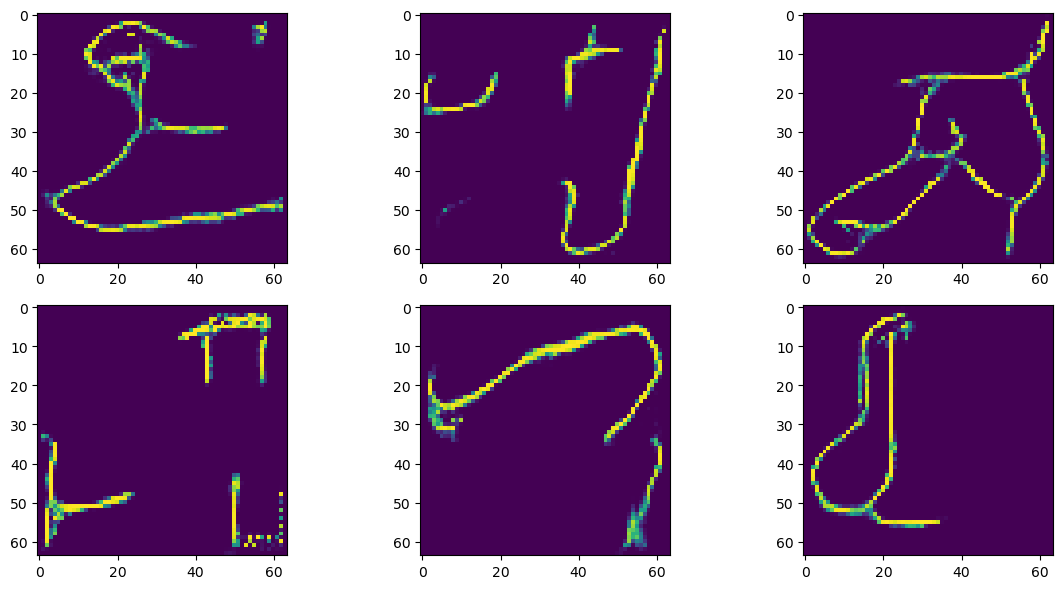

In [28]:
train(gen_model, dis_model, gan_model, data, latent_dim)